# rf-stacking 데모
* 알고리즘 rf, lgbm, lr 적용한 앙상블 기법  stacking 적용
* 개별 모델이 예측한 데이터를 다시 training set 으로 사용해서 학습  

## 라이브러리 import 및 설정

In [52]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

import seaborn as sns
import warnings
rcParams['figure.figsize'] = (16, 8)       #그림 사이즈 지정
plt.style.use('fivethirtyeight')           #그림 기본 스타일
pd.set_option('max_columns', 100)          #칼럼 100개 허용
pd.set_option("display.precision", 4)      #소수점 4자리허용
warnings.simplefilter('ignore')            #경고분 무시

## 학습데이터 로드

In [53]:
feature_file = 'C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\feature.csv'
sample_file  = 'C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\sample_submission.csv'
tst_file     = 'C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\testset.csv'
trn_file     = 'C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\trainset.csv'
val_dir      = Path('C:\\Users\\USER\\Desktop\\Dataset\\val')
tst_dir      = Path('C:\\Users\\USER\\Desktop\\Dataset\\tst')

## Stacking Feature 생성

In [54]:
model_names = ['lrcvPolyfeature', 'rfcvFeature', 'lgbmcvFeature']
trn = []
tst = []
feature_names = []
for model in model_names:
    trn.append(pd.read_csv(val_dir / f'{model}.val.csv', delimiter=',',header=None))
    tst.append(pd.read_csv(tst_dir / f'{model}.tst.csv', delimiter=',',header=None))
    feature_names += [f'{model}_0CO', f'{model}_1EL', f'{model}_2GR', f'{model}_3HI', f'{model}_4MI', f'{model}_5PH']
    
trn = np.hstack(trn)
tst = np.hstack(tst)
feature_names

['lrcvPolyfeature_0CO',
 'lrcvPolyfeature_1EL',
 'lrcvPolyfeature_2GR',
 'lrcvPolyfeature_3HI',
 'lrcvPolyfeature_4MI',
 'lrcvPolyfeature_5PH',
 'rfcvFeature_0CO',
 'rfcvFeature_1EL',
 'rfcvFeature_2GR',
 'rfcvFeature_3HI',
 'rfcvFeature_4MI',
 'rfcvFeature_5PH',
 'lgbmcvFeature_0CO',
 'lgbmcvFeature_1EL',
 'lgbmcvFeature_2GR',
 'lgbmcvFeature_3HI',
 'lgbmcvFeature_4MI',
 'lgbmcvFeature_5PH']

In [55]:
df = pd.read_csv(trn_file, header=None)
y = pd.DataFrame(df[0].values.flatten())
y.shape

(4280, 1)

In [56]:
seed=150
kfold=10

## Stratified K-Fold Cross Validation
*Stratified N-Fold CV: N-Fold CV에서 각각의 폴드에서 종속변수의 분포가 동일하도록 폴드를 나누는 방식.
현재 사용하는 데이터처럼 분류학습에서 종속변수의 범주의 분포가 균일하지 않을 때 사용된다.

In [57]:
cv = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=seed)

### [범주형 > 수치형 변환_종속변수]

In [85]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

label_str=y
label_int=le.fit_transform(label_str).astype('int')

label_int

array([3, 5, 2, ..., 1, 5, 1])

## Random Forest 모델 학습 

In [92]:
p_val = np.zeros((trn.shape[0], 6))
p_tst = np.zeros((tst.shape[0], 6))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = RandomForestClassifier(n_estimators=100,
                                 min_samples_leaf=10,
                                 max_features='auto',
                                 max_samples=.5,
                                 #max_samples=1,#n_estimators=500,
                                 #bootstrap=False,
                                 #max_features='auto',
                                 #max_samples=1,
                                 #n_estimators = 1000, 
                                 #max_depth = 30,
                                 #min_samples_leaf = 4,
                                 #min_samples_split = 8,
                                 random_state=seed,
                                 n_jobs=-1)
    
    clf.fit(trn[i_trn], label_int[i_trn])
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / kfold

training model for CV #1
training model for CV #2
training model for CV #3
training model for CV #4
training model for CV #5
training model for CV #6
training model for CV #7
training model for CV #8
training model for CV #9
training model for CV #10


** ( 범주값 출력: clf.pedict(), 확률값출력: clf.predict_proba() ) **

In [93]:
print(f'{accuracy_score(label_int, np.argmax(p_val, axis=1)) * 100:.4f}%')

91.5654%


## Simple way Cross Validation

In [94]:
scores = cross_val_score(clf, trn,y, cv=10) # model, train, target, cross validation
print('cross-val-score \n{}'.format(scores))
print('cross-val-score.mean \n{:.4f}%'.format(scores.mean()*100))

cross-val-score 
[0.9182243  0.93224299 0.92990654 0.9135514  0.90654206 0.9088785
 0.90420561 0.92523364 0.92757009 0.89953271]
cross-val-score.mean 
91.6589%


## 피처 중요도 시각화

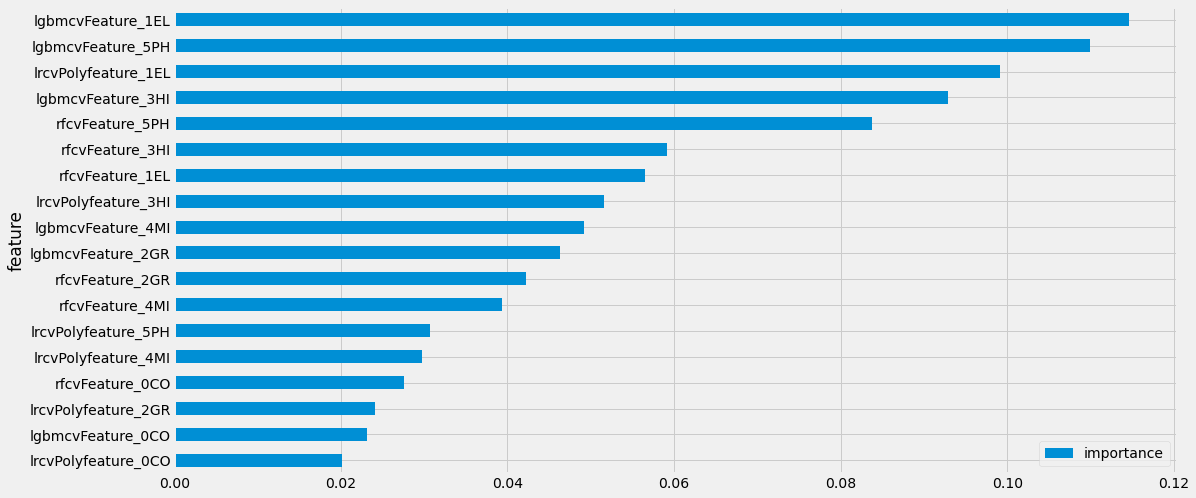

In [95]:
imp = pd.DataFrame({'feature': feature_names, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

### [수치형 > 범주형 변환_종속변수]

In [96]:
pt=np.zeros(shape=(1833,))
pt = pt.astype(np.int64)
for x in range(0,1833):
    pt[x] = np.argmax(p_tst[x,:])
target=le.inverse_transform(pt)
target

array(['HI', 'EL', 'HI', ..., 'PH', 'PH', 'HI'], dtype=object)

## 제출 파일 생성

In [97]:
#sub = pd.read_csv(sample_file)
#sub['class']
sub = pd.read_csv(sample_file)
sub['class'] = target
sub.to_csv('C:\\Users\\USER\\Desktop\\Dataset\\sub\\rfcvStacking-sub.csv',index=False,header=False)

In [ ]:
n_estimators=100,
                                 min_samples_leaf=10,
                                 max_features='auto',
                                 max_samples=.5,